In [1]:
import pandas as pd

bike_rentals = pd.read_csv('bike_rental_hour.csv')
print(bike_rentals.shape)
print(bike_rentals.head())

(17379, 17)
   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


In [2]:
bike_rentals['dteday'].dtype

dtype('O')

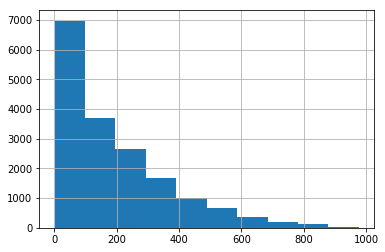

In [3]:
%matplotlib inline
bike_rentals['cnt'].hist()

In [4]:
print(bike_rentals.shape, bike_rentals['hr'].value_counts().sort_index())

def assign_label(x):
    d = {range(6, 12): 1, range(12, 18): 2, range(18, 24): 3, range(0, 6): 4}
    for i, j in d.items():
        if x in i:
            val = j
    return val

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
print(bike_rentals[['hr', 'time_label']].head(25))

(17379, 17) 0     726
1     724
2     715
3     697
4     697
5     717
6     725
7     727
8     727
9     727
10    727
11    727
12    728
13    729
14    729
15    729
16    730
17    730
18    728
19    728
20    728
21    728
22    728
23    728
Name: hr, dtype: int64
    hr  time_label
0    0           4
1    1           4
2    2           4
3    3           4
4    4           4
5    5           4
6    6           1
7    7           1
8    8           1
9    9           1
10  10           1
11  11           1
12  12           2
13  13           2
14  14           2
15  15           2
16  16           2
17  17           2
18  18           3
19  19           3
20  20           3
21  21           3
22  22           3
23  23           3
24   0           4


(17379, 18)
             instant    season        yr      mnth        hr   holiday  \
instant     1.000000  0.404046  0.866014  0.489164  0.004775  0.014723   
season      0.404046  1.000000  0.010742  0.830386  0.006117  0.009585   
yr          0.866014  0.010742  1.000000  0.010473  0.003867  0.006692   
mnth        0.489164  0.830386  0.010473  1.000000  0.005772  0.018430   
hr          0.004775  0.006117  0.003867  0.005772  1.000000  0.000479   
holiday     0.014723  0.009585  0.006692  0.018430  0.000479  1.000000   
weekday     0.001357  0.002335  0.004485  0.010400  0.003498  0.102088   
workingday  0.003416  0.013743  0.002196  0.003477  0.002285  0.252471   
weathersit  0.014198  0.014524  0.019157  0.005400  0.020203  0.017036   
temp        0.136178  0.312025  0.040913  0.201691  0.137603  0.027340   
atemp       0.137615  0.319380  0.039222  0.208096  0.133750  0.030973   
hum         0.009577  0.150625  0.083546  0.164411  0.276498  0.010588   
windspeed   0.074505  0.14

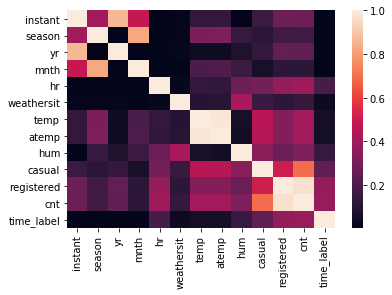

In [5]:
print(bike_rentals.shape)
print(bike_rentals.corr().abs())
corr = bike_rentals.corr()['cnt'].abs()
str_corr = corr[corr>0.1].index

import seaborn as sns
corrmat = bike_rentals[str_corr].corr().abs()
sns.heatmap(corrmat)

Those pairs of features have strong corelation to each other: instant vs. year; month vs. season; atemp vs. temp. We will exclude instant and keep year, exclude season and include month, and we will keep temp and exclude adjusted atemp. We are also going to exclude casual and registered.

In [6]:
data_clean = bike_rentals[str_corr].drop(['instant','season','atemp','casual', 'registered'], axis = 1)
##['instant','season','atemp',
data_rescale = (data_clean-data_clean.min())/(data_clean.max() - data_clean.min())
sorted_vars = data_rescale.var().sort_values()
print(sorted_vars)

cnt           0.034539
hum           0.037222
temp          0.038607
weathersit    0.045420
hr            0.090376
mnth          0.097729
time_label    0.138207
yr            0.250008
dtype: float64


Did not exclude any features with low variability since there are only 8 features left.

In [7]:
train = data_clean.sample(frac = 0.8, random_state = 1)
test = data_clean.loc[~bike_rentals.index.isin(train.index)]

print(data_clean.shape, train.shape, test.shape)

(17379, 8) (13903, 8) (3476, 8)


In [8]:
features = data_clean.drop('cnt', axis = 1).columns

from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(train[features], train['cnt'])
predictions = lm.predict(test[features])

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predictions, test['cnt'])**(1/2)
print(mse)
print(predictions[0:5])
print(test['cnt'].head())

131.34007420427565
[-125.59959414  127.80433685  120.73059728   57.20115546   78.62480824]
0      16
14    106
15    110
18     35
20     36
Name: cnt, dtype: int64


The mse is high, the turnout of this model does not look good. The prediction value can be negative at some points, too, which is not good.

In [9]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(train[features], train['cnt'])
predictions = dt.predict(test[features])

mse = mean_squared_error(predictions, test['cnt'])**(1/2)
print(mse)
print(predictions[0:5])
print(test['cnt'].head())

113.17669685228974
[39. 94. 75. 37. 89.]
0      16
14    106
15    110
18     35
20     36
Name: cnt, dtype: int64


In [10]:
dt = DecisionTreeRegressor(min_samples_leaf = 3)
dt.fit(train[features], train['cnt'])
predictions = dt.predict(test[features])

mse = mean_squared_error(predictions, test['cnt'])**(1/2)
print(mse)
print(predictions[0:5])
print(test['cnt'].head())

98.36800083565161
[ 30.66666667 118.25        70.         129.          83.5       ]
0      16
14    106
15    110
18     35
20     36
Name: cnt, dtype: int64


In [11]:
dt = DecisionTreeRegressor(min_samples_leaf = 4, max_depth = 9)
dt.fit(train[features], train['cnt'])
predictions = dt.predict(test[features])

mse = mean_squared_error(predictions, test['cnt'])**(1/2)
print(mse)
print(predictions[0:5])
print(test['cnt'].head())

92.1967091854542
[ 22.83333333 176.55555556 115.03389831 103.16666667  69.48571429]
0      16
14    106
15    110
18     35
20     36
Name: cnt, dtype: int64


The mse is a lot smaller than the model from linear regression. The predicted values looked more reasonable. After adjusting parameters in the decision tree regressor, I realized that min_sample_leaf = 4 and max_depth = 9 yields the best result

In [12]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

rf.fit(train[features], train['cnt'])
predictions = rf.predict(test[features])

mse = mean_squared_error(predictions, test['cnt'])**(1/2)
print(mse)
print(predictions[0:5])
print(test['cnt'].head())

/Users/sitanlydiayan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


92.93921502030746
[ 31.6 113.6  98.   69.1  77.3]
0      16
14    106
15    110
18     35
20     36
Name: cnt, dtype: int64


In [13]:
rf = RandomForestRegressor(min_samples_split = 6)

rf.fit(train[features], train['cnt'])
predictions = rf.predict(test[features])

mse = mean_squared_error(predictions, test['cnt'])**(1/2)
print(mse)
print(predictions[0:5])
print(test['cnt'].head())

/Users/sitanlydiayan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


89.0550367082277
[ 22.15357143 120.8825     112.7775      74.53589744  64.35357143]
0      16
14    106
15    110
18     35
20     36
Name: cnt, dtype: int64


Random Forest had lowese MSE